In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pandas as pd

import gc #garbage collector

In [8]:
# Importa los datasets de score y titles
score = pd.read_csv('ignore/score.csv')
titles = pd.read_csv('data/all.csv')

In [6]:
score.tail(2)

,index,userId,score,timestamp,movieId,year,platform
11024287,1499998,124380,4.5,1196787089,ns7881,2007,n
11024288,1499999,124380,1.5,1196785847,as883,2007,a


In [7]:
def load_data(name):
    df = pd.read_csv(name, header = None, names = ['userId','score'], usecols = [0,1])
    
    # En algunas ocasiones forzar un tipo de dato hace que se ahorre mucho lugar en memoria.
    df['score'] = df['score'].astype(float)
    return df

# df1 = load_data('ignore/score.csv')
print(score.shape)

(11024289, 7)


In [9]:
titles.tail(2) # No coinciden los encabezados de ambos datasets para movieId e id

,id,platform,type,title,director,cast,country,date_added,release_year,duration_int,duration_type,listed_in,description
22996,ns8806,netflix,movie,zoom,peter hewitt,"tim allen, courteney cox, chevy chase, kate ma...",united states,2020-01-11,2006,88,min,"children & family movies, comedies","dragged from civilian life, a former superhero..."
22997,ns8807,netflix,movie,zubaan,mozez singh,"vicky kaushal, sarah-jane dias, raaghav chanan...",india,2019-03-02,2015,111,min,"dramas, international movies, music & musicals",a scrappy but poor boy worms his way into a ty...


In [ ]:
# Filtra las columnas userId, movieId y score del dataset score y las columnas id y title del dataset title.
score = score[['userId','movieId','score']]
titles = titles[['id','title']]
titles = titles.rename(columns={'id':'movieId'}) # Cambia el nombre para que haya coincidencia

In [25]:
# Usuarios únicos 115077
print('users:',len(score['userId'].unique()))
# Calificaciones de películas por usuario
scoresByUser = score.groupby(['userId']).count()
scoresByUser.tail()

users: 115077


,movieId,score
userId,,
270892,75,75
270893,190,190
270894,148,148
270895,20,20
270896,260,260


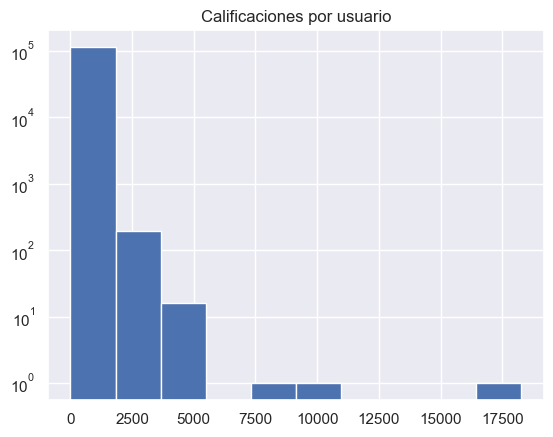

In [26]:
plt.hist(scoresByUser.score, log= True)
plt.title('Calificaciones por usuario')
plt.show()